In [16]:
# coding: utf-8
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pylab as plt
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
import numpy as np
from matplotlib import pyplot as plt 
%matplotlib inline
import matplotlib.colors as colors
import matplotlib.cm as cm 

 
#GP-UCB Code
class GPUCB(object):

  def __init__(self, meshgrid, environment, beta=100):
    '''
    beta (optional): Hyper-parameter to tune the exploration-exploitation
    balance. If beta is large, it emphasizes the variance of the unexplored
    solution solution (i.e. larger curiosity)
    '''
    self.meshgrid = np.array(meshgrid)
    self.environment = environment
    self.beta = beta
    self.neighbours_considered  = 2
    self.X_grid = self.meshgrid.reshape(self.meshgrid.shape[0], -1).T
    #print(self.X_grid)
    self.mu = np.array([0. for _ in range(self.X_grid.shape[0])])
    #print(self.mu.shape)
    self.sigma = np.array([0.5 for _ in range(self.X_grid.shape[0])])
    self.X = []
    self.T = []
    self.index_value = 0
    self.sampling_index = []
   
  def argmax_ucb(self):
    
    #index_value = np.argmax(self.mu + self.sigma * np.sqrt(self.beta))
    prev_index_value = self.index_value
    #print type(self.X_grid)
    prev_sampling_loc = self.X_grid[self.index_value]
    print prev_index_value, prev_sampling_loc
    min_mu = min(self.mu)
    min_sigma =  min(self.sigma)
    n = self.neighbours_considered
    t = 0
    for i in range(len(self.mu)):
        if prev_index_value-self.neighbours_considered <= i <= prev_index_value+self.neighbours_considered:
            if t==0:
                #print "c",i
                t += 1
                indx1 = i
                continue
            else:
                #print "c",i
                t+=1
                continue  
             
    #print indx1, t
    for  j in range(self.neighbours_considered):
      for i in range(len(self.mu)):
        indx_l = indx1 - 24*(j+1)
        indx_u = indx1+t - 24*(j+1)
        indx_l1 = indx1 + 24*(j+1)
        indx_u1 = indx1+t + 24*(j+1)
        if i in self.sampling_index:
            self.mu[i]= min_mu
            self.sigma[i] = min_sigma
            continue
        if prev_index_value-self.neighbours_considered <= i <= prev_index_value+self.neighbours_considered:
                   continue             
                
        elif indx_l <= i < indx_u:
                    #print indx_l, indx_u
                    #print "_c",i
                    continue
                
        elif indx_l1 <= i < indx_u1:
                    #print "___c",i
                    continue
                
        
         
        self.mu[i]= min_mu
        self.sigma[i] = min_sigma
    matrix = self.mu + self.sigma * np.sqrt(self.beta)
    #plt.pcolormesh(self.meshgrid[0], self.meshgrid[1],matrix.reshape(self.meshgrid[0].shape))
    #plt.title("Checking...")
    
    self.index_value = np.argmax(self.mu + self.sigma * np.sqrt(self.beta))

    self.sampling_index.append(self.index_value)
    predicted_value = self.mu[self.index_value]
    true_value = self.sample(self.X_grid[self.index_value])
    if abs(true_value - predicted_value) > 0.50:
        self.neighbours_considered -= 4
        print "radius decreased to ",self.neighbours_considered
    elif abs(true_value - predicted_value) < 0.25:
        self.neighbours_considered += 4
        print "radius increased to ",self.neighbours_considered

  def learn(self):
    self.argmax_ucb()
    gp = GaussianProcessRegressor()
    gp.fit(self.X, self.T)
    print gp.score(self.X, self.T)
    self.mu, self.sigma = gp.predict(self.X_grid, return_std=True)
    return self.mu
    #check info gain and change neighboursconsidered

  def sample(self, x):
    t = self.environment.sample(x)
    self.X.append(x)
    self.T.append(t)
    #print "value after", t
    return t
    

  def plot(self):
    
    fig = plt.figure(figsize=(18, 8))
    fig.suptitle("Iteration %02d" %len(self.X))
    
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.plot_wireframe(self.meshgrid[0], self.meshgrid[1],
        self.mu.reshape(self.meshgrid[0].shape), alpha=0.5, color='g')
    ax.plot_wireframe(self.meshgrid[0], self.meshgrid[1],
        self.environment.sample(self.meshgrid), alpha=0.5, color='b')
    ax.scatter([x[0] for x in self.X], [x[1] for x in self.X], self.T, c='r',
        marker='o', alpha=1.0)
    ax1 = fig.add_subplot(1, 2, 2)
    ax1 = plt.subplot(122)
    ax1.pcolormesh(self.meshgrid[0], self.meshgrid[1],self.mu.reshape(self.meshgrid[0].shape))
  
    plt.savefig('fig_%02d.png' % len(self.X))




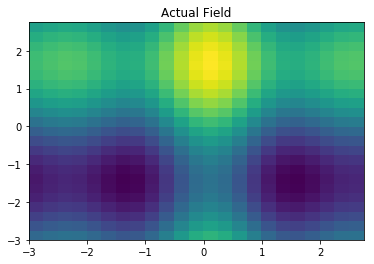

In [17]:
if __name__ == '__main__':
  class DummyEnvironment(object):
    def sample(self, j):
      return np.sinc(j[0])+np.sin(j[1])

  x = np.arange(-3, 3, 0.25)
  y = np.arange(-3, 3, 0.25)
  env = DummyEnvironment()
  agent = GPUCB(np.meshgrid(x, y), env)

  #Actual Field
  X, Y = np.meshgrid(x, y) 
  #Z = np.sinc(X)+ np.sin(Y)
  Z = np.sinc(X)+ np.sin(Y) 
  plt.pcolormesh(X,Y,Z)
  plt.title("Actual Field")
  
  

Sampling Location 0 is
0 [-3. -3.]
radius increased to  6
0.0
Sampling Location 1 is
0 [-3. -3.]
1.0
Sampling Location 2 is
6 [-1.5 -3. ]
radius decreased to  2
1.0
Sampling Location 3 is
12 [ 0. -3.]
1.0
Sampling Location 4 is
14 [ 0.5 -3. ]
radius increased to  6
1.0


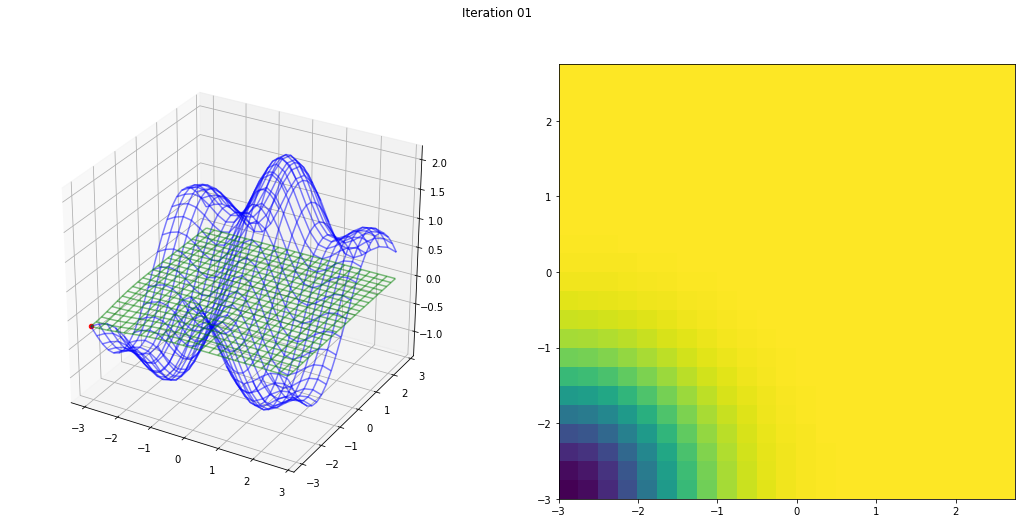

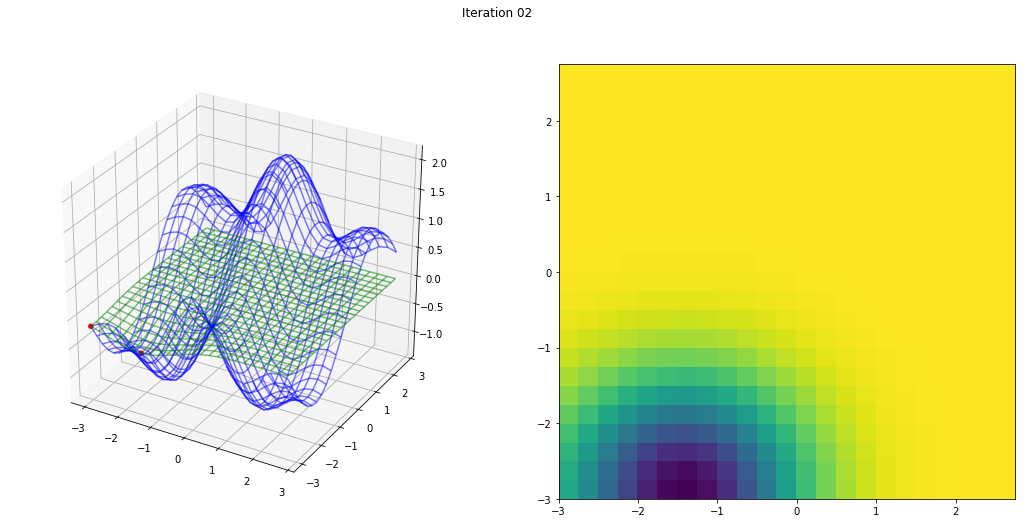

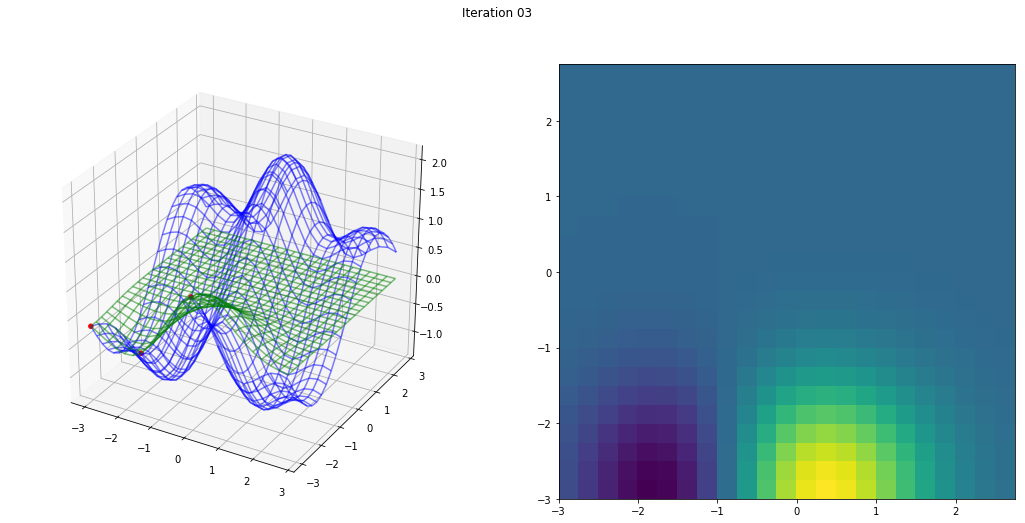

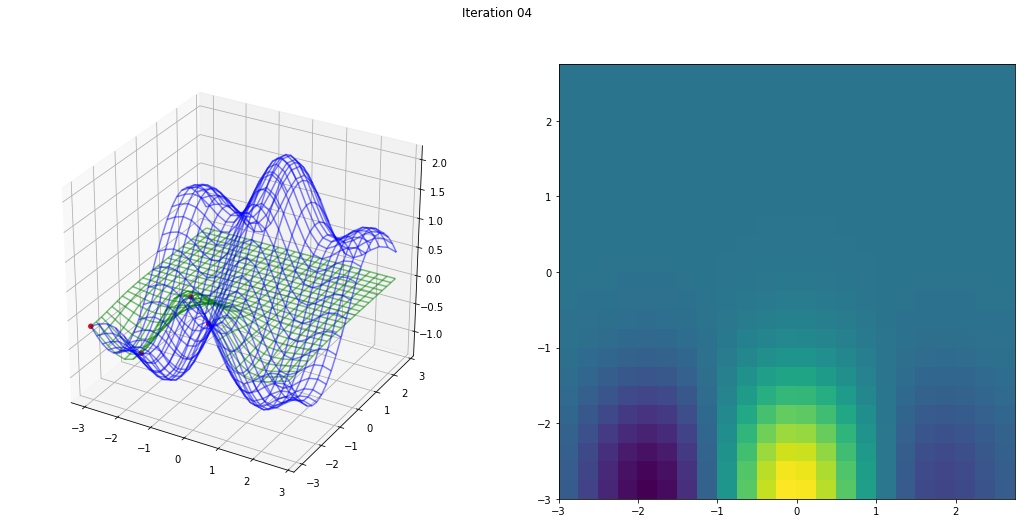

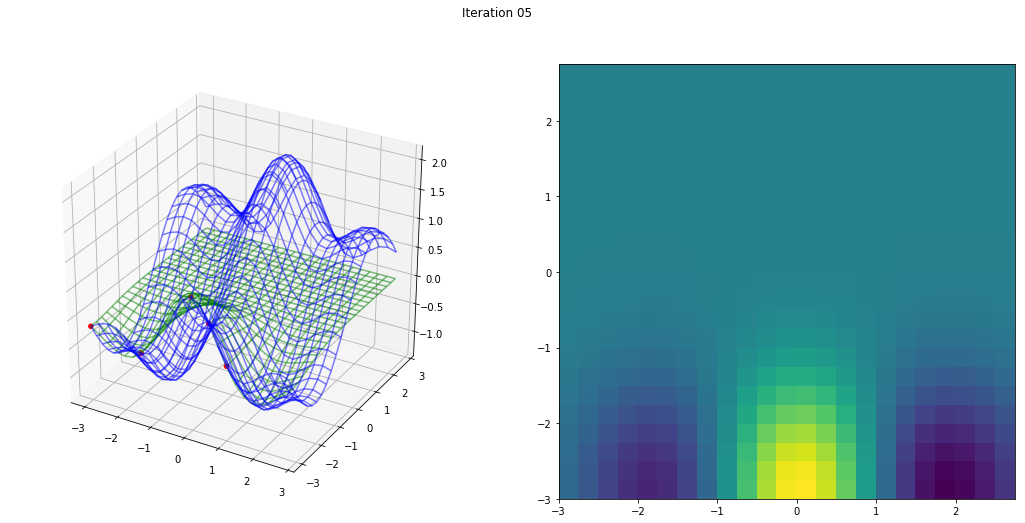

In [18]:
#Mapping the Field--
for i in range(5):
    print "Sampling Location "+ str(i) + " is" 
    predicted = agent.learn()
    agent.plot()

In [19]:
print Z.shape
print "ok",predicted.shape
k=0
error = []
for i in Z:
    for j in i:
        error.append(abs(j-predicted[k]))
        k+=1
        
MappingError = sum(error)
MappingError

(24, 24)
ok (576,)


390.88038154113156